In [3]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.config import asset_types
from jre_utils.visualize import plot_time_series
from jre_utils.process import get_cumulative_growth, get_cumulative_growth_from_base

from jre_utils.datapath import (
    factor_data_paths,
    model_built_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [30]:
asset_type = "building"
years_ahead = 2

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

dataset_paths = {
    "transactions": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = "gmean"
# metric_key = "median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric


In [31]:
dataset_key = "transactions"
core_path = dataset_paths[dataset_key]
population_path = factor_data_paths["processed"]["population"]["municipality"]
migration_path = factor_data_paths["processed"]["migration"]["municipality"]

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_built_data_path = model_built_data_paths[dataset_name]

In [41]:
df = pd.read_csv(core_path)
df = df.assign(asset_type=asset_type)

population_df = pd.read_csv(population_path)
migration_df = pd.read_csv(migration_path)

df = (
    df.merge(population_df, on=group_by_columns, how="left")
    .merge(migration_df, on=group_by_columns, how="left")
)

df = df.sort_values(by=["year", "area_code"], ascending=True)
df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
df["noise"] = np.random.normal(0, 1, df.shape[0])

In [42]:
variables = ["yearly_price_growth", "net_migration_ratio", "noise"]
columns = group_by_columns + variables
df = df[columns].dropna()

In [43]:
area_code = 13101
area_df = df[df["area_code"] == area_code]
area_df


,area,area_code,year,yearly_price_growth,net_migration_ratio,noise
1579,Tokyo-to Chiyoda-ku,13101,2006,0.115103,0.019416,2.183850
1580,Tokyo-to Chiyoda-ku,13101,2007,0.180474,0.008594,0.046475
1581,Tokyo-to Chiyoda-ku,13101,2008,-0.009674,0.010735,0.054914
1582,Tokyo-to Chiyoda-ku,13101,2009,-0.241944,0.019982,-0.287783
1583,Tokyo-to Chiyoda-ku,13101,2010,0.074627,0.012579,0.549758
1584,Tokyo-to Chiyoda-ku,13101,2011,-0.216327,0.013117,-0.836189
1585,Tokyo-to Chiyoda-ku,13101,2012,0.026180,0.019949,1.286062
1586,Tokyo-to Chiyoda-ku,13101,2013,0.450003,0.035358,-0.882725
1587,Tokyo-to Chiyoda-ku,13101,2014,-0.066893,0.043446,-0.089548
1588,Tokyo-to Chiyoda-ku,13101,2015,0.066683,0.023197,-0.262686


In [44]:
for variable in variables:
    plot_time_series(
        area_df,
        variable,
        group_by_columns,
        granularity_columns,
        f"{variable} over time",
        width=1000,
        height=400,
        showlegend=False,
        # visible="legendonly",
        # highlight=True,
        # highlight_range=(2020, 2022)
    )

In [49]:
def get_prefecture_code(area_code):
    return int(area_code) // 1000

prefecture_codes = list(range(47 + 1)) # 0 for Japan and 1-47 for the prefectures

cross_correlation_dict = {
    area_code: {
        dep: {factor: {"lag": [], "corr": [], "corr_norm": []} for factor in variables}
        for dep in variables
    }
    for area_code in list(df["area_code"].unique()) + prefecture_codes
}

In [52]:
# Keep lag between -5 and 5

for area_code in df["area_code"].unique():
    area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)
    for factor in variables:
        for dep in variables:
            corr_df = area_df.set_index("year").dropna()
            dep_curve, factor_curve = corr_df[dep], corr_df[factor]

            if len(corr_df) > 0:
                zero_lag_index, min_lag, max_lag = len(factor_curve) - 1, -5, 5
                
                # Lags
                lags = np.arange(min_lag, max_lag + 1) # [-5, 5]
                
                min_index = zero_lag_index + min_lag
                max_index = zero_lag_index + max_lag + 1


                # Cross Corr
                cross_corr = np.correlate(dep_curve, factor_curve, mode="full")[min_index:max_index]

                # Normalize Cross Corr
                auto_corr_x = np.correlate(dep_curve, dep_curve)[0]
                auto_corr_y = np.correlate(factor_curve, factor_curve)[0]

                normalization_factor = np.sqrt(auto_corr_x * auto_corr_y)
                cross_corr_normalized = cross_corr / normalization_factor

                # Store
                cross_correlation_dict[area_code][dep][factor]["lag"] = lags
                cross_correlation_dict[area_code][dep][factor]["corr"] = cross_corr
                cross_correlation_dict[area_code][dep][factor][
                    "corr_norm"
                ] = cross_corr_normalized

In [53]:
# very inefficient
for prefecture_code in prefecture_codes:
    # break
    for factor in variables:
        for dep in variables:

            cross_corr_df = pd.DataFrame({"lag": []})

            for area_code in cross_correlation_dict.keys():
                if get_prefecture_code(area_code) == prefecture_code or prefecture_code == 0:
                    cross_corr_series = pd.DataFrame(
                        {
                            "lag": cross_correlation_dict[area_code][dep][factor][
                                "lag"
                            ],
                            area_code: cross_correlation_dict[area_code][dep][factor][
                                "corr_norm"
                            ],
                        }
                    )
                    cross_corr_df = cross_corr_df.merge(
                        cross_corr_series, on="lag", how="outer"
                    )

            prefecture_avg_cross_corr = (
                cross_corr_df.set_index("lag").sort_index().mean(axis=1)
            )

            cross_correlation_dict[prefecture_code][dep][factor][
                "lag"
            ] = prefecture_avg_cross_corr.index

            cross_correlation_dict[prefecture_code][dep][factor][
                "corr_norm"
            ] = prefecture_avg_cross_corr.values

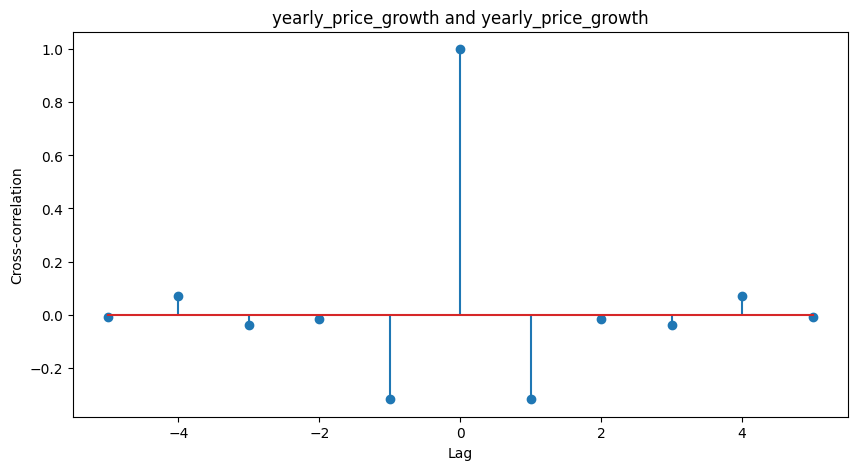

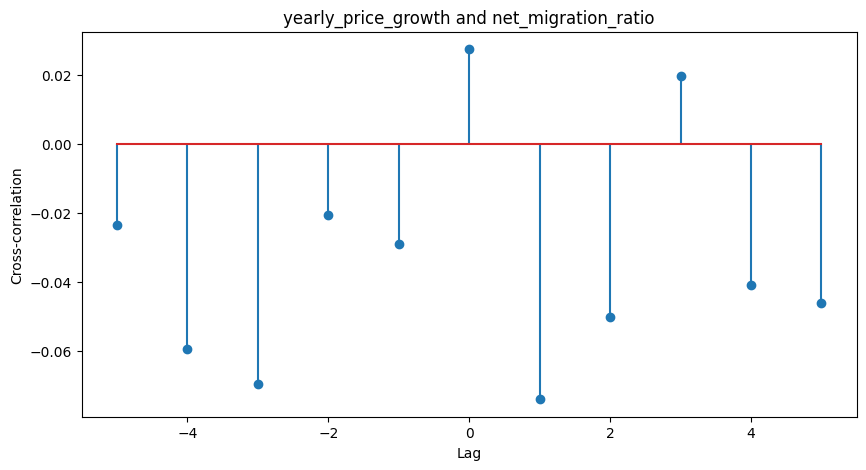

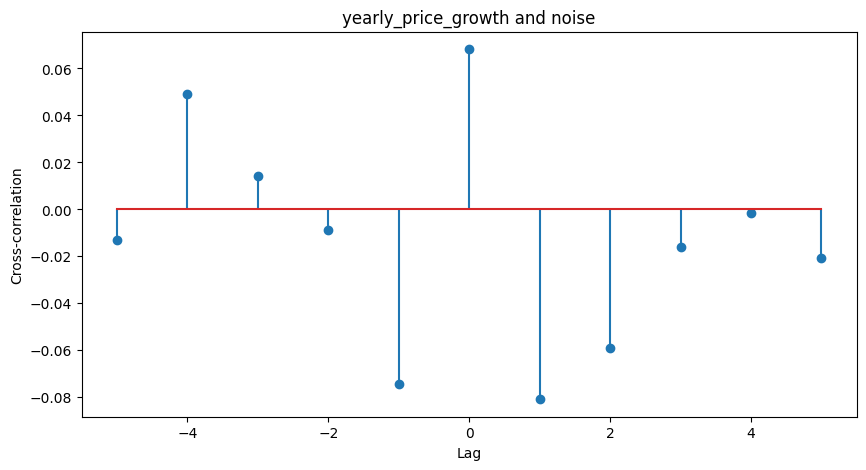

In [63]:
area_code = 16
x_var = "yearly_price_growth"

for y_var in variables:
    cross_corr_norm = cross_correlation_dict[area_code][x_var][y_var]["corr_norm"]
    lags = cross_correlation_dict[area_code][x_var][y_var]["lag"]

    # Plotting the cross-correlation vs lags
    plt.figure(figsize=(10, 5))
    plt.stem(lags, cross_corr_norm)
    plt.title(f'{x_var} and {y_var}')
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.show()